In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pandas import DataFrame
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

In [2]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def relu(x):
    return np.maximum(0, x)

def sigmoid_derivat(dA, x):
    """
    sigmoid'(x) = x' * sigmoid(x) * (1 - sigmoid(x))
    """
    f = sigmoid(x)
    
    return dA * f * (1 - f)

def relu_derivat(dA, x):
    """ relu'(x) = [0, daca x <=0 altfel 1] * x' """
    dX = np.array(dA, copy=True)
    dX[x <= 0] = 0
    
    return dX

In [3]:
def bce(y, y_hat):
    n = y.shape[1]
    
    loss = (-1 / n) * (np.dot(y, np.log(y_hat).T) + np.dot(1 - y, np.log(1 - y_hat).T))
    
    return np.squeeze(loss)

def accuracy_score(y, y_hat):
    classes = (y_hat >= 0.5).astype(int)

    return (classes == y).mean()

In [4]:
class MLP():
    """
    Varianta definire MLP cu specificare input si output pentru fiecare unitate.
    """
    def __init__(self, architecture, random_seed=42):
        np.random.seed(random_seed)
        
        self.activation_functions = {
            'sigmoid': sigmoid,
            'relu': relu
        }
        
        self.derivatives = {
            'relu': relu_derivat,
            'sigmoid': sigmoid_derivat
        }
        
        
        number_of_layers = len(architecture)
        params_values = {}

        for idx, layer in enumerate(architecture):
            layer_idx = idx + 1
            
            layer_input_size = layer["input_dim"]
            
            layer_output_size = layer["units"]

            params_values['W' + str(layer_idx)] = np.random.randn(layer_output_size, layer_input_size) * 0.1
            
            params_values['b' + str(layer_idx)] = np.random.randn(layer_output_size, 1) * 0.1
            
            
        self.params = params_values
        self.architecture = architecture
        
    def summary(self):
        print("{:^15s} {:^15s} {:^15s} {:^15s} {:^15s} {:^15s} \n".format(
            "Input shape",
            "Output shape",
            "Weights shape",
            "Bias shape",
            "Activation",
            "Params"
        ))
        print("{:_<100s}".format(''))
        total_params = 0
        for idx, layer in enumerate(self.architecture):
            layer_idx = idx + 1
            in_shape = layer["input_dim"]
            out_shape = layer["units"]
            
            weights_shape = self.params['W' + str(layer_idx)].shape
            bias_shape = self.params['b' + str(layer_idx)].shape
            
            activation = layer["activation"]
            
            weights_params = 1
            for dim in weights_shape:
                weights_params *= dim
            
            bias_params = 1
            for dim in bias_shape:
                bias_params *= dim
            
            num_params = bias_params + weights_params
            total_params += num_params
            
            print("{:^15d} {:^15d} {:^15s} {:^15s} {:^15s} {:^15d} \n".format(
                in_shape,
                out_shape,
                str(weights_shape),
                str(bias_shape),
                activation,
                num_params
            ))
            print("-"*100)
            
        print("Total number of parameters: {}".format(total_params))

    def forward(self, w, b, x, activation='relu'):
        z = np.dot(w, x) + b
    
        return self.activation_functions[activation](z), z
        
    def predict(self, x):
        """ Functie cu care realizam predictii prin metoda propagarii inainte. """
        memory = {}
        current_activation = x

        for idx, layer in enumerate(self.architecture):
            layer_idx = idx + 1
            previous_activation = current_activation
            
            activation_function = layer["activation"]
            
            w = self.params["W" + str(layer_idx)]
            
            b = self.params["b" + str(layer_idx)]

            current_activation, z = self.forward(w, b, previous_activation, activation_function)

            memory["x" + str(idx)] = previous_activation
            memory["z" + str(layer_idx)] = z

        return current_activation, memory
    
    def backward(self, dA_curr, W_curr, b_curr, Z_curr, A_prev, activation="relu"):
        # number of examples
        m = A_prev.shape[1]

        # selection of activation function
        if activation is "relu":
            backward_activation_func = relu_derivat
        elif activation is "sigmoid":
            backward_activation_func = sigmoid_derivat
        else:
            raise Exception('Non-supported activation function')

        # calculation of the activation function derivative
        dZ_curr = backward_activation_func(dA_curr, Z_curr)

        # derivative of the matrix W
        dW_curr = np.dot(dZ_curr, A_prev.T) / m
        # derivative of the vector b
        db_curr = np.sum(dZ_curr, axis=1, keepdims=True) / m
        # derivative of the matrix A_prev
        dA_prev = np.dot(W_curr.T, dZ_curr)

        return dA_prev, dW_curr, db_curr
    
    def backward_propagation(self, Y_hat, Y, memory):
        grads_values = {}
    
        # number of examples
        m = Y.shape[1]
        # a hack ensuring the same shape of the prediction vector and labels vector
        Y = Y.reshape(Y_hat.shape)

        # initiation of gradient descent algorithm
        dA_prev = - (np.divide(Y, Y_hat) - np.divide(1 - Y, 1 - Y_hat));

        for layer_idx_prev, layer in reversed(list(enumerate(self.architecture))):
            # we number network layers from 1
            layer_idx_curr = layer_idx_prev + 1
            # extraction of the activation function for the current layer
            activ_function_curr = layer["activation"]

            dA_curr = dA_prev

            A_prev = memory["x" + str(layer_idx_prev)]
            Z_curr = memory["z" + str(layer_idx_curr)]

            W_curr = self.params["W" + str(layer_idx_curr)]
            b_curr = self.params["b" + str(layer_idx_curr)]

            dA_prev, dW_curr, db_curr = self.backward(
                dA_curr, W_curr, b_curr, Z_curr, A_prev, activ_function_curr)

            grads_values["dW" + str(layer_idx_curr)] = dW_curr
            grads_values["db" + str(layer_idx_curr)] = db_curr

        return grads_values
    
    def update(self, grads_values, learning_rate):
        for layer_idx, layer in enumerate(self.architecture, 1):
            self.params["W" + str(layer_idx)] -= learning_rate * grads_values["dW" + str(layer_idx)]        
            self.params["b" + str(layer_idx)] -= learning_rate * grads_values["db" + str(layer_idx)]
            
    def train(self, X, Y, epochs, learning_rate):
        cost_history = []
        accuracy_history = []

        for i in range(epochs):
            Y_hat, mem = self.predict(X)
            cost = bce(Y, Y_hat)
            
            cost_history.append(cost)
            accuracy = accuracy_score(Y, Y_hat)
            accuracy_history.append(accuracy)

            grads_values = self.backward_propagation(Y_hat, Y, mem)
            
            self.update(grads_values, learning_rate)
            
            if(i % 50 == 0):
                print("Iteration: {:05} - cost: {:.5f} - accuracy: {:.5f}".format(i, cost, accuracy))

        return cost_history, accuracy_history

In [5]:
architecture = [
    {
        "input_dim": 2,
        "units": 25,
        "activation": "relu"
    },
    {
        "input_dim": 25,
        "units": 50,
        "activation": "relu"
    },
    {
        "input_dim": 50,
        "units": 50,
        "activation": "relu"
    },
    {
        "input_dim": 50,
        "units": 25,
        "activation": "relu"
    },
    {
        "input_dim": 25,
        "units": 1,
        "activation": "sigmoid"
    },
]

In [6]:
nn = MLP(architecture)

In [7]:
nn.summary()

  Input shape    Output shape    Weights shape    Bias shape      Activation        Params      

____________________________________________________________________________________________________
       2              25            (25, 2)         (25, 1)          relu             75        

----------------------------------------------------------------------------------------------------
      25              50           (50, 25)         (50, 1)          relu            1300       

----------------------------------------------------------------------------------------------------
      50              50           (50, 50)         (50, 1)          relu            2550       

----------------------------------------------------------------------------------------------------
      50              25           (25, 50)         (25, 1)          relu            1275       

----------------------------------------------------------------------------------------------------
     

In [8]:
X, y = make_moons(n_samples = 1000, noise=0.2, random_state=100)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

In [9]:
X.shape

(1000, 2)

In [10]:
y.shape

(1000,)

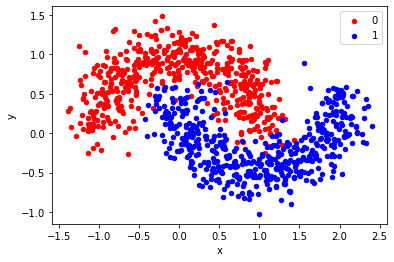

In [11]:
# scatter plot, dots colored by class value
df = DataFrame(dict(x=X[:,0], y=X[:,1], label=y))
colors = {0:'red', 1:'blue'}
fig, ax = plt.subplots()
grouped = df.groupby('label')
for key, group in grouped:
    group.plot(ax=ax, kind='scatter', x='x', y='y', label=key, color=colors[key])
plt.show()

In [12]:
hist = nn.train(X_train.T, y_train.reshape(1, y_train.shape[0]), 10000, 0.1)

Iteration: 00000 - cost: 0.69509 - accuracy: 0.49556
Iteration: 00050 - cost: 0.69228 - accuracy: 0.49667
Iteration: 00100 - cost: 0.69102 - accuracy: 0.50444
Iteration: 00150 - cost: 0.68836 - accuracy: 0.67556
Iteration: 00200 - cost: 0.68028 - accuracy: 0.82444
Iteration: 00250 - cost: 0.64183 - accuracy: 0.84000
Iteration: 00300 - cost: 0.43950 - accuracy: 0.85444
Iteration: 00350 - cost: 0.29377 - accuracy: 0.87667
Iteration: 00400 - cost: 0.28068 - accuracy: 0.87778
Iteration: 00450 - cost: 0.27648 - accuracy: 0.88000
Iteration: 00500 - cost: 0.27201 - accuracy: 0.88111
Iteration: 00550 - cost: 0.26648 - accuracy: 0.88000
Iteration: 00600 - cost: 0.25979 - accuracy: 0.88000
Iteration: 00650 - cost: 0.25365 - accuracy: 0.88333
Iteration: 00700 - cost: 0.24837 - accuracy: 0.88556
Iteration: 00750 - cost: 0.24416 - accuracy: 0.88667
Iteration: 00800 - cost: 0.23042 - accuracy: 0.89222
Iteration: 00850 - cost: 0.21399 - accuracy: 0.90000
Iteration: 00900 - cost: 0.18444 - accuracy: 0

Iteration: 07750 - cost: 0.06096 - accuracy: 0.97222
Iteration: 07800 - cost: 0.06093 - accuracy: 0.97222
Iteration: 07850 - cost: 0.06089 - accuracy: 0.97222
Iteration: 07900 - cost: 0.06087 - accuracy: 0.97222
Iteration: 07950 - cost: 0.06088 - accuracy: 0.97222
Iteration: 08000 - cost: 0.06085 - accuracy: 0.97222
Iteration: 08050 - cost: 0.06090 - accuracy: 0.97222
Iteration: 08100 - cost: 0.06089 - accuracy: 0.97222
Iteration: 08150 - cost: 0.06073 - accuracy: 0.97222
Iteration: 08200 - cost: 0.06089 - accuracy: 0.97222
Iteration: 08250 - cost: 0.06090 - accuracy: 0.97222
Iteration: 08300 - cost: 0.06071 - accuracy: 0.97222
Iteration: 08350 - cost: 0.06069 - accuracy: 0.97222
Iteration: 08400 - cost: 0.06073 - accuracy: 0.97222
Iteration: 08450 - cost: 0.06080 - accuracy: 0.97222
Iteration: 08500 - cost: 0.06071 - accuracy: 0.97222
Iteration: 08550 - cost: 0.06067 - accuracy: 0.97222
Iteration: 08600 - cost: 0.06067 - accuracy: 0.97222
Iteration: 08650 - cost: 0.06074 - accuracy: 0

In [13]:
pred, _ = nn.predict(X_test.T)

In [14]:
accuracy_score(y_test, pred)

1.0

# Implementarea aceleiasi arhitecturi folosind Tensorflow

In [17]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Input, Dropout

In [18]:
model = Sequential([
    Input(shape=(2)),
    Dense(25, activation='relu'),
    Dense(50, activation='relu'),
    Dense(50, activation='relu'),
    Dense(25, activation='relu'),
    Dense(1, activation='sigmoid')
])
model.compile(optimizer='sgd', loss='binary_crossentropy', metrics=['accuracy'])

In [19]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 25)                75        
_________________________________________________________________
dense_1 (Dense)              (None, 50)                1300      
_________________________________________________________________
dense_2 (Dense)              (None, 50)                2550      
_________________________________________________________________
dense_3 (Dense)              (None, 25)                1275      
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 26        
Total params: 5,226
Trainable params: 5,226
Non-trainable params: 0
_________________________________________________________________


In [20]:
model.fit(
    epochs=1000,
    x=X_train,
    y=y_train,
    batch_size=128,
    validation_data=(X_test, y_test)
)

Epoch 1/1000
8/8 [==============================] - 2s 124ms/step - loss: 0.6885 - accuracy: 0.5218 - val_loss: 0.6860 - val_accuracy: 0.6600
Epoch 2/1000
8/8 [==============================] - 0s 12ms/step - loss: 0.6833 - accuracy: 0.7071 - val_loss: 0.6824 - val_accuracy: 0.7600
Epoch 3/1000
8/8 [==============================] - 0s 11ms/step - loss: 0.6786 - accuracy: 0.8261 - val_loss: 0.6788 - val_accuracy: 0.7300
Epoch 4/1000
8/8 [==============================] - 0s 11ms/step - loss: 0.6742 - accuracy: 0.8176 - val_loss: 0.6761 - val_accuracy: 0.7300
Epoch 5/1000
8/8 [==============================] - 0s 11ms/step - loss: 0.6709 - accuracy: 0.8179 - val_loss: 0.6728 - val_accuracy: 0.8200
Epoch 6/1000
8/8 [==============================] - 0s 12ms/step - loss: 0.6684 - accuracy: 0.8374 - val_loss: 0.6700 - val_accuracy: 0.8100
Epoch 7/1000
8/8 [==============================] - 0s 12ms/step - loss: 0.6645 - accuracy: 0.8296 - val_loss: 0.6667 - val_accuracy: 0.8200
Epoch 8/1000

Epoch 59/1000
8/8 [==============================] - 0s 10ms/step - loss: 0.3982 - accuracy: 0.8366 - val_loss: 0.4390 - val_accuracy: 0.8100
Epoch 60/1000
8/8 [==============================] - 0s 12ms/step - loss: 0.3883 - accuracy: 0.8355 - val_loss: 0.4314 - val_accuracy: 0.8200
Epoch 61/1000
8/8 [==============================] - 0s 11ms/step - loss: 0.3965 - accuracy: 0.8261 - val_loss: 0.4279 - val_accuracy: 0.8200
Epoch 62/1000
8/8 [==============================] - 0s 10ms/step - loss: 0.3804 - accuracy: 0.8430 - val_loss: 0.4234 - val_accuracy: 0.8200
Epoch 63/1000
8/8 [==============================] - 0s 12ms/step - loss: 0.3668 - accuracy: 0.8450 - val_loss: 0.4159 - val_accuracy: 0.8200
Epoch 64/1000
8/8 [==============================] - 0s 13ms/step - loss: 0.3823 - accuracy: 0.8429 - val_loss: 0.4140 - val_accuracy: 0.8200
Epoch 65/1000
8/8 [==============================] - 0s 12ms/step - loss: 0.3793 - accuracy: 0.8393 - val_loss: 0.4118 - val_accuracy: 0.8200
Epoch 

8/8 [==============================] - 0s 11ms/step - loss: 0.2879 - accuracy: 0.8720 - val_loss: 0.3067 - val_accuracy: 0.8500
Epoch 117/1000
8/8 [==============================] - 0s 14ms/step - loss: 0.2696 - accuracy: 0.8823 - val_loss: 0.3051 - val_accuracy: 0.8600
Epoch 118/1000
8/8 [==============================] - 0s 15ms/step - loss: 0.2904 - accuracy: 0.8636 - val_loss: 0.3036 - val_accuracy: 0.8600
Epoch 119/1000
8/8 [==============================] - 0s 14ms/step - loss: 0.2773 - accuracy: 0.8803 - val_loss: 0.3059 - val_accuracy: 0.8500
Epoch 120/1000
8/8 [==============================] - 0s 16ms/step - loss: 0.2745 - accuracy: 0.8746 - val_loss: 0.3015 - val_accuracy: 0.8500
Epoch 121/1000
8/8 [==============================] - 0s 32ms/step - loss: 0.2744 - accuracy: 0.8830 - val_loss: 0.3055 - val_accuracy: 0.8600
Epoch 122/1000
8/8 [==============================] - 0s 12ms/step - loss: 0.2808 - accuracy: 0.8695 - val_loss: 0.3035 - val_accuracy: 0.8500
Epoch 123/1000

8/8 [==============================] - 0s 11ms/step - loss: 0.2338 - accuracy: 0.8913 - val_loss: 0.2629 - val_accuracy: 0.8600
Epoch 174/1000
8/8 [==============================] - 0s 11ms/step - loss: 0.2257 - accuracy: 0.9059 - val_loss: 0.2677 - val_accuracy: 0.8600
Epoch 175/1000
8/8 [==============================] - 0s 11ms/step - loss: 0.2276 - accuracy: 0.8998 - val_loss: 0.2675 - val_accuracy: 0.8500
Epoch 176/1000
8/8 [==============================] - 0s 12ms/step - loss: 0.2362 - accuracy: 0.9002 - val_loss: 0.2605 - val_accuracy: 0.8600
Epoch 177/1000
8/8 [==============================] - 0s 11ms/step - loss: 0.2351 - accuracy: 0.8928 - val_loss: 0.2620 - val_accuracy: 0.8700
Epoch 178/1000
8/8 [==============================] - 0s 11ms/step - loss: 0.2376 - accuracy: 0.9048 - val_loss: 0.2577 - val_accuracy: 0.8600
Epoch 179/1000
8/8 [==============================] - 0s 10ms/step - loss: 0.2377 - accuracy: 0.8952 - val_loss: 0.2562 - val_accuracy: 0.8600
Epoch 180/1000

8/8 [==============================] - 0s 11ms/step - loss: 0.2093 - accuracy: 0.9081 - val_loss: 0.2196 - val_accuracy: 0.9000
Epoch 231/1000
8/8 [==============================] - 0s 13ms/step - loss: 0.2001 - accuracy: 0.9186 - val_loss: 0.2251 - val_accuracy: 0.8800
Epoch 232/1000
8/8 [==============================] - 0s 13ms/step - loss: 0.1981 - accuracy: 0.9209 - val_loss: 0.2240 - val_accuracy: 0.8900
Epoch 233/1000
8/8 [==============================] - 0s 10ms/step - loss: 0.1749 - accuracy: 0.9340 - val_loss: 0.2142 - val_accuracy: 0.8900
Epoch 234/1000
8/8 [==============================] - 0s 12ms/step - loss: 0.2021 - accuracy: 0.9190 - val_loss: 0.2138 - val_accuracy: 0.8900
Epoch 235/1000
8/8 [==============================] - 0s 12ms/step - loss: 0.1903 - accuracy: 0.9218 - val_loss: 0.2259 - val_accuracy: 0.8900
Epoch 236/1000
8/8 [==============================] - 0s 11ms/step - loss: 0.1907 - accuracy: 0.9174 - val_loss: 0.2172 - val_accuracy: 0.8900
Epoch 237/1000

8/8 [==============================] - 0s 11ms/step - loss: 0.1590 - accuracy: 0.9313 - val_loss: 0.1702 - val_accuracy: 0.9200
Epoch 288/1000
8/8 [==============================] - 0s 12ms/step - loss: 0.1493 - accuracy: 0.9430 - val_loss: 0.1830 - val_accuracy: 0.9300
Epoch 289/1000
8/8 [==============================] - 0s 13ms/step - loss: 0.1571 - accuracy: 0.9365 - val_loss: 0.1783 - val_accuracy: 0.9300
Epoch 290/1000
8/8 [==============================] - 0s 11ms/step - loss: 0.1397 - accuracy: 0.9472 - val_loss: 0.1650 - val_accuracy: 0.9200
Epoch 291/1000
8/8 [==============================] - 0s 11ms/step - loss: 0.1499 - accuracy: 0.9441 - val_loss: 0.1665 - val_accuracy: 0.9100
Epoch 292/1000
8/8 [==============================] - 0s 13ms/step - loss: 0.1512 - accuracy: 0.9416 - val_loss: 0.1708 - val_accuracy: 0.9300
Epoch 293/1000
8/8 [==============================] - 0s 13ms/step - loss: 0.1534 - accuracy: 0.9382 - val_loss: 0.1625 - val_accuracy: 0.9100
Epoch 294/1000

8/8 [==============================] - 0s 12ms/step - loss: 0.1370 - accuracy: 0.9503 - val_loss: 0.1584 - val_accuracy: 0.9500
Epoch 345/1000
8/8 [==============================] - 0s 13ms/step - loss: 0.1425 - accuracy: 0.9540 - val_loss: 0.1315 - val_accuracy: 0.9500
Epoch 346/1000
8/8 [==============================] - 0s 11ms/step - loss: 0.1253 - accuracy: 0.9580 - val_loss: 0.1239 - val_accuracy: 0.9500
Epoch 347/1000
8/8 [==============================] - 0s 13ms/step - loss: 0.1206 - accuracy: 0.9585 - val_loss: 0.1223 - val_accuracy: 0.9500
Epoch 348/1000
8/8 [==============================] - 0s 12ms/step - loss: 0.1198 - accuracy: 0.9616 - val_loss: 0.1202 - val_accuracy: 0.9600
Epoch 349/1000
8/8 [==============================] - 0s 12ms/step - loss: 0.1092 - accuracy: 0.9588 - val_loss: 0.1203 - val_accuracy: 0.9500
Epoch 350/1000
8/8 [==============================] - 0s 11ms/step - loss: 0.1190 - accuracy: 0.9541 - val_loss: 0.1199 - val_accuracy: 0.9500
Epoch 351/1000

8/8 [==============================] - 0s 11ms/step - loss: 0.1038 - accuracy: 0.9573 - val_loss: 0.0934 - val_accuracy: 0.9800
Epoch 402/1000
8/8 [==============================] - 0s 9ms/step - loss: 0.0971 - accuracy: 0.9656 - val_loss: 0.0925 - val_accuracy: 0.9800
Epoch 403/1000
8/8 [==============================] - 0s 12ms/step - loss: 0.0946 - accuracy: 0.9684 - val_loss: 0.0900 - val_accuracy: 0.9800
Epoch 404/1000
8/8 [==============================] - 0s 12ms/step - loss: 0.1003 - accuracy: 0.9581 - val_loss: 0.0933 - val_accuracy: 0.9800
Epoch 405/1000
8/8 [==============================] - 0s 10ms/step - loss: 0.0912 - accuracy: 0.9654 - val_loss: 0.0949 - val_accuracy: 0.9500
Epoch 406/1000
8/8 [==============================] - 0s 11ms/step - loss: 0.1056 - accuracy: 0.9540 - val_loss: 0.0880 - val_accuracy: 0.9900
Epoch 407/1000
8/8 [==============================] - 0s 10ms/step - loss: 0.0984 - accuracy: 0.9599 - val_loss: 0.0887 - val_accuracy: 0.9800
Epoch 408/1000


8/8 [==============================] - 0s 11ms/step - loss: 0.0812 - accuracy: 0.9687 - val_loss: 0.0781 - val_accuracy: 0.9700
Epoch 459/1000
8/8 [==============================] - 0s 9ms/step - loss: 0.0836 - accuracy: 0.9688 - val_loss: 0.0779 - val_accuracy: 0.9800
Epoch 460/1000
8/8 [==============================] - 0s 10ms/step - loss: 0.0857 - accuracy: 0.9692 - val_loss: 0.0733 - val_accuracy: 0.9800
Epoch 461/1000
8/8 [==============================] - 0s 11ms/step - loss: 0.0846 - accuracy: 0.9645 - val_loss: 0.0722 - val_accuracy: 0.9900
Epoch 462/1000
8/8 [==============================] - 0s 10ms/step - loss: 0.1053 - accuracy: 0.9577 - val_loss: 0.0730 - val_accuracy: 0.9900
Epoch 463/1000
8/8 [==============================] - 0s 10ms/step - loss: 0.0797 - accuracy: 0.9689 - val_loss: 0.0718 - val_accuracy: 0.9900
Epoch 464/1000
8/8 [==============================] - 0s 10ms/step - loss: 0.0887 - accuracy: 0.9649 - val_loss: 0.0734 - val_accuracy: 0.9800
Epoch 465/1000


8/8 [==============================] - 0s 11ms/step - loss: 0.0771 - accuracy: 0.9754 - val_loss: 0.0606 - val_accuracy: 1.0000
Epoch 516/1000
8/8 [==============================] - 0s 11ms/step - loss: 0.0836 - accuracy: 0.9590 - val_loss: 0.0621 - val_accuracy: 0.9900
Epoch 517/1000
8/8 [==============================] - 0s 13ms/step - loss: 0.0779 - accuracy: 0.9658 - val_loss: 0.0692 - val_accuracy: 1.0000
Epoch 518/1000
8/8 [==============================] - 0s 11ms/step - loss: 0.0791 - accuracy: 0.9675 - val_loss: 0.0682 - val_accuracy: 0.9800
Epoch 519/1000
8/8 [==============================] - 0s 11ms/step - loss: 0.0995 - accuracy: 0.9643 - val_loss: 0.0665 - val_accuracy: 0.9800
Epoch 520/1000
8/8 [==============================] - 0s 11ms/step - loss: 0.0888 - accuracy: 0.9686 - val_loss: 0.0637 - val_accuracy: 0.9800
Epoch 521/1000
8/8 [==============================] - 0s 10ms/step - loss: 0.0846 - accuracy: 0.9676 - val_loss: 0.0785 - val_accuracy: 0.9600
Epoch 522/1000

8/8 [==============================] - 0s 10ms/step - loss: 0.0812 - accuracy: 0.9718 - val_loss: 0.0606 - val_accuracy: 0.9900
Epoch 573/1000
8/8 [==============================] - 0s 11ms/step - loss: 0.0847 - accuracy: 0.9644 - val_loss: 0.0580 - val_accuracy: 0.9900
Epoch 574/1000
8/8 [==============================] - 0s 13ms/step - loss: 0.0779 - accuracy: 0.9711 - val_loss: 0.0592 - val_accuracy: 0.9900
Epoch 575/1000
8/8 [==============================] - 0s 11ms/step - loss: 0.0813 - accuracy: 0.9685 - val_loss: 0.0595 - val_accuracy: 0.9900
Epoch 576/1000
8/8 [==============================] - 0s 12ms/step - loss: 0.0675 - accuracy: 0.9727 - val_loss: 0.0570 - val_accuracy: 0.9900
Epoch 577/1000
8/8 [==============================] - 0s 12ms/step - loss: 0.0844 - accuracy: 0.9644 - val_loss: 0.0544 - val_accuracy: 0.9900
Epoch 578/1000
8/8 [==============================] - 0s 10ms/step - loss: 0.0758 - accuracy: 0.9694 - val_loss: 0.0531 - val_accuracy: 1.0000
Epoch 579/1000

8/8 [==============================] - 0s 10ms/step - loss: 0.0640 - accuracy: 0.9786 - val_loss: 0.0531 - val_accuracy: 0.9900
Epoch 630/1000
8/8 [==============================] - 0s 10ms/step - loss: 0.0822 - accuracy: 0.9692 - val_loss: 0.0538 - val_accuracy: 0.9900
Epoch 631/1000
8/8 [==============================] - 0s 9ms/step - loss: 0.0710 - accuracy: 0.9708 - val_loss: 0.0527 - val_accuracy: 0.9900
Epoch 632/1000
8/8 [==============================] - 0s 10ms/step - loss: 0.0677 - accuracy: 0.9769 - val_loss: 0.0528 - val_accuracy: 0.9900
Epoch 633/1000
8/8 [==============================] - 0s 11ms/step - loss: 0.0720 - accuracy: 0.9766 - val_loss: 0.0527 - val_accuracy: 0.9900
Epoch 634/1000
8/8 [==============================] - 0s 11ms/step - loss: 0.0800 - accuracy: 0.9693 - val_loss: 0.0521 - val_accuracy: 0.9900
Epoch 635/1000
8/8 [==============================] - 0s 10ms/step - loss: 0.0759 - accuracy: 0.9699 - val_loss: 0.0476 - val_accuracy: 0.9900
Epoch 636/1000


8/8 [==============================] - 0s 11ms/step - loss: 0.0838 - accuracy: 0.9585 - val_loss: 0.0723 - val_accuracy: 0.9700
Epoch 687/1000
8/8 [==============================] - 0s 12ms/step - loss: 0.0747 - accuracy: 0.9735 - val_loss: 0.0538 - val_accuracy: 0.9800
Epoch 688/1000
8/8 [==============================] - 0s 13ms/step - loss: 0.0815 - accuracy: 0.9636 - val_loss: 0.0486 - val_accuracy: 1.0000
Epoch 689/1000
8/8 [==============================] - 0s 12ms/step - loss: 0.0698 - accuracy: 0.9711 - val_loss: 0.0504 - val_accuracy: 0.9900
Epoch 690/1000
8/8 [==============================] - 0s 12ms/step - loss: 0.0812 - accuracy: 0.9674 - val_loss: 0.0502 - val_accuracy: 0.9900
Epoch 691/1000
8/8 [==============================] - 0s 12ms/step - loss: 0.0704 - accuracy: 0.9709 - val_loss: 0.0504 - val_accuracy: 0.9900
Epoch 692/1000
8/8 [==============================] - 0s 12ms/step - loss: 0.0812 - accuracy: 0.9654 - val_loss: 0.0507 - val_accuracy: 1.0000
Epoch 693/1000

8/8 [==============================] - 0s 10ms/step - loss: 0.0769 - accuracy: 0.9701 - val_loss: 0.0444 - val_accuracy: 1.0000
Epoch 744/1000
8/8 [==============================] - 0s 11ms/step - loss: 0.0770 - accuracy: 0.9672 - val_loss: 0.0544 - val_accuracy: 0.9800
Epoch 745/1000
8/8 [==============================] - 0s 12ms/step - loss: 0.0887 - accuracy: 0.9626 - val_loss: 0.0813 - val_accuracy: 0.9500
Epoch 746/1000
8/8 [==============================] - 0s 12ms/step - loss: 0.0912 - accuracy: 0.9625 - val_loss: 0.0572 - val_accuracy: 0.9800
Epoch 747/1000
8/8 [==============================] - 0s 11ms/step - loss: 0.0768 - accuracy: 0.9656 - val_loss: 0.0493 - val_accuracy: 0.9900
Epoch 748/1000
8/8 [==============================] - 0s 12ms/step - loss: 0.0622 - accuracy: 0.9755 - val_loss: 0.0606 - val_accuracy: 0.9800
Epoch 749/1000
8/8 [==============================] - 0s 13ms/step - loss: 0.0810 - accuracy: 0.9672 - val_loss: 0.0521 - val_accuracy: 0.9800
Epoch 750/1000

8/8 [==============================] - 0s 10ms/step - loss: 0.0680 - accuracy: 0.9726 - val_loss: 0.0450 - val_accuracy: 1.0000
Epoch 801/1000
8/8 [==============================] - 0s 10ms/step - loss: 0.0679 - accuracy: 0.9746 - val_loss: 0.0461 - val_accuracy: 0.9900
Epoch 802/1000
8/8 [==============================] - 0s 11ms/step - loss: 0.0725 - accuracy: 0.9660 - val_loss: 0.0457 - val_accuracy: 1.0000
Epoch 803/1000
8/8 [==============================] - 0s 10ms/step - loss: 0.0750 - accuracy: 0.9709 - val_loss: 0.0444 - val_accuracy: 1.0000
Epoch 804/1000
8/8 [==============================] - 0s 10ms/step - loss: 0.0730 - accuracy: 0.9668 - val_loss: 0.0544 - val_accuracy: 0.9800
Epoch 805/1000
8/8 [==============================] - 0s 9ms/step - loss: 0.0864 - accuracy: 0.9622 - val_loss: 0.0471 - val_accuracy: 0.9900
Epoch 806/1000
8/8 [==============================] - 0s 10ms/step - loss: 0.0743 - accuracy: 0.9657 - val_loss: 0.0468 - val_accuracy: 0.9900
Epoch 807/1000


8/8 [==============================] - 0s 11ms/step - loss: 0.0739 - accuracy: 0.9690 - val_loss: 0.0427 - val_accuracy: 1.0000
Epoch 858/1000
8/8 [==============================] - 0s 10ms/step - loss: 0.0683 - accuracy: 0.9677 - val_loss: 0.0447 - val_accuracy: 1.0000
Epoch 859/1000
8/8 [==============================] - 0s 10ms/step - loss: 0.0711 - accuracy: 0.9718 - val_loss: 0.0411 - val_accuracy: 1.0000
Epoch 860/1000
8/8 [==============================] - 0s 10ms/step - loss: 0.0631 - accuracy: 0.9724 - val_loss: 0.0972 - val_accuracy: 0.9500
Epoch 861/1000
8/8 [==============================] - 0s 10ms/step - loss: 0.0809 - accuracy: 0.9674 - val_loss: 0.0367 - val_accuracy: 1.0000
Epoch 862/1000
8/8 [==============================] - 0s 10ms/step - loss: 0.0797 - accuracy: 0.9600 - val_loss: 0.0399 - val_accuracy: 1.0000
Epoch 863/1000
8/8 [==============================] - 0s 11ms/step - loss: 0.0704 - accuracy: 0.9663 - val_loss: 0.0407 - val_accuracy: 1.0000
Epoch 864/1000

8/8 [==============================] - 0s 10ms/step - loss: 0.0760 - accuracy: 0.9682 - val_loss: 0.0348 - val_accuracy: 1.0000
Epoch 915/1000
8/8 [==============================] - 0s 11ms/step - loss: 0.0665 - accuracy: 0.9687 - val_loss: 0.0393 - val_accuracy: 1.0000
Epoch 916/1000
8/8 [==============================] - 0s 10ms/step - loss: 0.0721 - accuracy: 0.9657 - val_loss: 0.0406 - val_accuracy: 1.0000
Epoch 917/1000
8/8 [==============================] - 0s 10ms/step - loss: 0.0553 - accuracy: 0.9805 - val_loss: 0.0359 - val_accuracy: 1.0000
Epoch 918/1000
8/8 [==============================] - 0s 28ms/step - loss: 0.0605 - accuracy: 0.9729 - val_loss: 0.0383 - val_accuracy: 1.0000
Epoch 919/1000
8/8 [==============================] - 0s 11ms/step - loss: 0.0670 - accuracy: 0.9688 - val_loss: 0.0731 - val_accuracy: 0.9700
Epoch 920/1000
8/8 [==============================] - 0s 11ms/step - loss: 0.0798 - accuracy: 0.9745 - val_loss: 0.0384 - val_accuracy: 1.0000
Epoch 921/1000

8/8 [==============================] - 0s 10ms/step - loss: 0.0630 - accuracy: 0.9769 - val_loss: 0.0429 - val_accuracy: 1.0000
Epoch 972/1000
8/8 [==============================] - 0s 10ms/step - loss: 0.0739 - accuracy: 0.9680 - val_loss: 0.0413 - val_accuracy: 1.0000
Epoch 973/1000
8/8 [==============================] - 0s 10ms/step - loss: 0.0691 - accuracy: 0.9751 - val_loss: 0.0385 - val_accuracy: 1.0000
Epoch 974/1000
8/8 [==============================] - 0s 10ms/step - loss: 0.0651 - accuracy: 0.9692 - val_loss: 0.0411 - val_accuracy: 1.0000
Epoch 975/1000
8/8 [==============================] - 0s 10ms/step - loss: 0.0678 - accuracy: 0.9757 - val_loss: 0.0623 - val_accuracy: 0.9800
Epoch 976/1000
8/8 [==============================] - 0s 11ms/step - loss: 0.1120 - accuracy: 0.9514 - val_loss: 0.0375 - val_accuracy: 1.0000
Epoch 977/1000
8/8 [==============================] - 0s 11ms/step - loss: 0.0692 - accuracy: 0.9721 - val_loss: 0.0395 - val_accuracy: 1.0000
Epoch 978/1000

In [21]:
model.evaluate(X_test, y_test)

4/4 [==============================] - 0s 2ms/step - loss: 0.0380 - accuracy: 1.0000


[0.03804000839591026, 1.0]